# **Seep Detection using U-Net in TensorFlow**

The code is written using Python and TensorFlow as a framework. UNet is a popular and effective architecture for image segmentation tasks. UNet Architecture has been implemented to perform the image segmentation task. Data augmentation has been done and then the data has been split into 80-10-10 ratio for train-validation-test.

A custom loss function comprising evaluation metrics, dice loss and bce loss is used. Adam optimizer is used to update the model's weights during training. While training, the model's performance is monitored using the dice coefficient and IoU metrics. Adam's optimizer has been used to train the model. Early stopping has been implemented and the model would train for 50 epochs. When the validation loss does not improve for 10 consecutive epochs, training will stop early.

Finally, three comparison plots for IoU, loss and dice coefficient are generated for both train and validation sets. The performance on test set can be seen from the comparison images of ground truth vs predictions. At the end, we save the model as well the weights.

In [1]:
from google.colab import drive
drive.mount('/content/drive')#mount google drive

Mounted at /content/drive


In [2]:
import tarfile
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from keras import layers
import keras
import keras.backend as K
from tqdm.notebook import tqdm
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras.models import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
# extracting contents of .tar.gz file
with tarfile.open('/content/drive/MyDrive/seep/seep_detection.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/drive/MyDrive/seep')

In [4]:
tf.config.list_physical_devices('GPU') #check if conencted to GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **I. Reading Dataset**

In [5]:
def read_dataset(tr_images_path,tr_masks_path):
  images = []
  masks = []

  for file_path in tqdm(os.listdir(tr_images_path)):
    image_path=tr_images_path + file_path
    images.append(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))

    mask_path=tr_masks_path + file_path
    masks.append(plt.imread(mask_path))

  X = np.array(images)
  y = np.array(masks)
  return X, y

In [6]:
train_images_path = '/content/drive/MyDrive/seep/seep_detection/train_images_256/'
train_masks_path = '/content/drive/MyDrive/seep/seep_detection/train_masks_256/'

seeps,masks= read_dataset(train_images_path,train_masks_path)

print('Shape of seeps =',seeps.shape)
print('Shape of masks =',masks.shape)

  0%|          | 0/790 [00:00<?, ?it/s]

Shape of seeps = (790, 256, 256, 3)
Shape of masks = (790, 256, 256)


Thus, the dataset has 790 images.

## **II. Visualizing the seep and mask**

In [7]:
def generate_seep_mask_plots(seep_image, mask_image):
    fig, axes = plt.subplots(1,2, figsize=(10,10))

    axes[0].imshow(seep_image)
    axes[0].set_title("Seep Image",fontweight="bold")
    axes[0].set_axis_off()

    axes[1].imshow(mask_image)
    axes[1].set_title("Mask Image",fontweight="bold")
    axes[1].set_axis_off()

    plt.show()

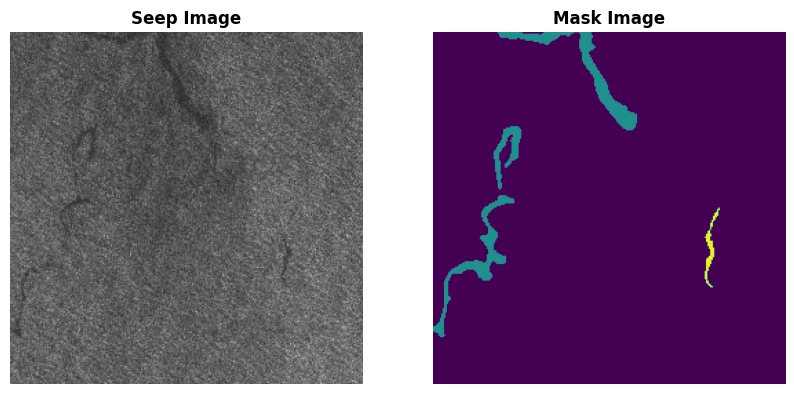

In [8]:
# Visualize any random image along with the mask
index = random.randint(0, len(seeps))
generate_seep_mask_plots(seeps[index], masks[index])

## **III. Preprocess Data**


In [9]:
features = (seeps / 255) # normalize the image pixel values to the range [0, 1]
label = (np.expand_dims(masks, -1) > 0).astype(np.float64)

## **IV. Train-Val-Test Split**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Shape of X_train= ",X_train.shape)
print("Shape of y_train= ",y_train.shape)
print()
print("Shape of X_val= ",X_val.shape)
print("Shape of y_val= ",y_val.shape)
print()
print("Shape of X_test= ",X_test.shape)
print("Shape of y_test= ",y_test.shape)


Shape of X_train=  (632, 256, 256, 3)
Shape of y_train=  (632, 256, 256, 1)

Shape of X_val=  (79, 256, 256, 3)
Shape of y_val=  (79, 256, 256, 1)

Shape of X_test=  (79, 256, 256, 3)
Shape of y_test=  (79, 256, 256, 1)


## **V. Data Augmentation and Data Generator**

In [11]:
batch_size = 32
data_gen_args = dict(rotation_range=90,# rotation
                     width_shift_range=0.1, # horizontal shift
                     horizontal_flip=True, # horizontal flip
                     vertical_flip=True,# vertical flip
                     fill_mode='constant',# to fill points outside boundary with color cval=0(black)
                     cval=0
                     )

# create data generators with specified data augmentation arguments
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

# apply data augmentation to training images and training masks
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# create generator for augmented image train data
image_generator = image_datagen.flow(
    X_train,
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

mask_generator = mask_datagen.flow(
    y_train,
    batch_size=batch_size,
    shuffle=True,
    seed=seed)


In [12]:
# combine generators into one which yields image and masks
training_generator = zip(image_generator, mask_generator)

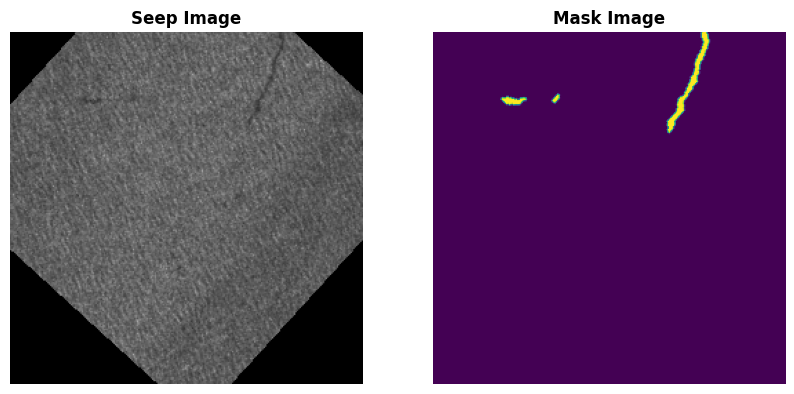

In [13]:
#viewing the data after data augmentation
for seep_img, mask_img in training_generator:
    mask_test = mask_img[0][:,:,0]
    seep_test = seep_img[0]
    break

generate_seep_mask_plots(seep_test, mask_test)

## **VI. U-Net Architecture**

In [14]:

# https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((256, 256, 3))# input image=(256,256,3)

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

## **VII. Evaluation Metrics**

**Dice Loss:** Dice Loss emphasizes the intersection of pixels and is less sensitive to false positives and false negatives.

**BCE Loss:** Binary Cross Entropy loss is used to penalize incorrect predictions more severely, pushing the model towards better convergence and more accurate predictions. It is a popular choice for image segmentation task as it has the ability to classify an image as belonging to one of two classes (binary problem).

**Custom Loss Function:** A custom loss function was created by summing the dice loss and BCE loss

**IoU:** IoU is used for assessing the quality of image segmentation models because it considers both the true positive and false positive rates.The higher the IoU value, the better the segmentation performance of the model.

In [15]:
 #https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
def dice_coef(y_true, y_pred, smooth=100):
  '''Function to calculate dice coefficient'''
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return dice


def dice_coef_loss(y_true, y_pred):
  '''Function to calculate dice loss'''
  return 1 - dice_coef(y_true, y_pred)


def bce_loss(y_true, y_pred):
  '''Function to calculate BCE loss'''
  return binary_crossentropy(y_true, y_pred)


def combined_loss(y_true, y_pred):
  '''Function to calculate custom loss function '''
  return bce_loss(y_true, y_pred)+dice_coef_loss(y_true, y_pred)

## **VIII. Training the model**

In [16]:
model=UNet()

model.compile(optimizer=Adam(), loss=combined_loss, metrics=[dice_coef,tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1])])

In [17]:
print('Summary of model:')
model.summary()

Summary of model:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                           

In [18]:
steps=len(X_train)//batch_size

history = model.fit(training_generator,
                    steps_per_epoch=steps,
                    validation_data=(X_val, y_val),
                    validation_steps=len(X_val)//batch_size ,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],# if the validation loss does not improve for 10 consecutive epochs, training will stop early
                    epochs=50)

Epoch 1/50
19/19 [==============================] - 48s 2s/step - loss: 1.1867 - dice_coef: 0.0172 - binary_io_u: 0.4931 - val_loss: 1.0555 - val_dice_coef: 0.0281 - val_binary_io_u: 0.4916
Epoch 2/50
19/19 [==============================] - 12s 669ms/step - loss: 1.0435 - dice_coef: 0.0354 - binary_io_u: 0.4942 - val_loss: 1.0456 - val_dice_coef: 0.0404 - val_binary_io_u: 0.4916
Epoch 3/50
19/19 [==============================] - 13s 686ms/step - loss: 1.0324 - dice_coef: 0.0440 - binary_io_u: 0.4939 - val_loss: 1.0362 - val_dice_coef: 0.0434 - val_binary_io_u: 0.4916
Epoch 4/50
19/19 [==============================] - 13s 693ms/step - loss: 1.0216 - dice_coef: 0.0496 - binary_io_u: 0.4941 - val_loss: 1.0243 - val_dice_coef: 0.0506 - val_binary_io_u: 0.4916
Epoch 5/50
19/19 [==============================] - 13s 676ms/step - loss: 1.0085 - dice_coef: 0.0645 - binary_io_u: 0.4943 - val_loss: 1.0073 - val_dice_coef: 0.0666 - val_binary_io_u: 0.4916
Epoch 6/50
19/19 [====================

## **IX. Plots showing performance of model**

In [19]:
def plot_metrics(history,train_param, val_param, param_name):
  '''Function to plot a metric for both train and validation set to understand the performance'''
  plt.figure(figsize=(6,6))
  plt.plot(history.history[train_param])
  plt.plot(history.history[val_param])
  plt.title('Plot of '+str(param_name)+' for Train and Validation',fontweight='bold')
  plt.ylabel(str(param_name))
  plt.xlabel('Epoch number')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

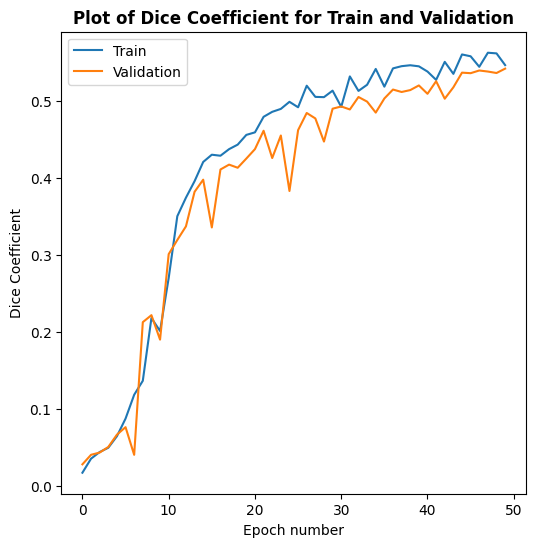

In [20]:
plot_metrics(history,'dice_coef', 'val_dice_coef', 'Dice Coefficient')

An increasing value of the Dice coefficient indicates a higher similarity or overlap between the predicted segmentation mask and the ground truth mask in an image segmentation task. Thus, increasing dice coefficient shows that the model is able to train.

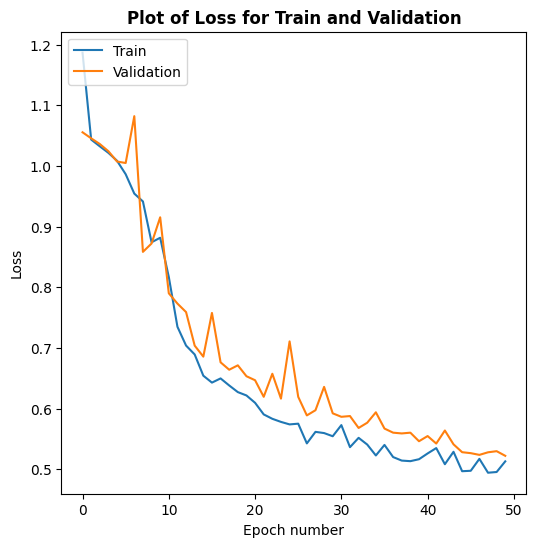

In [21]:
plot_metrics(history,'loss', 'val_loss', 'Loss')

The loss function shows the optimization objective for training process. Decreasing loss indicates that the model is moving towards a better solution, where its predictions are closer to the ground truth values.

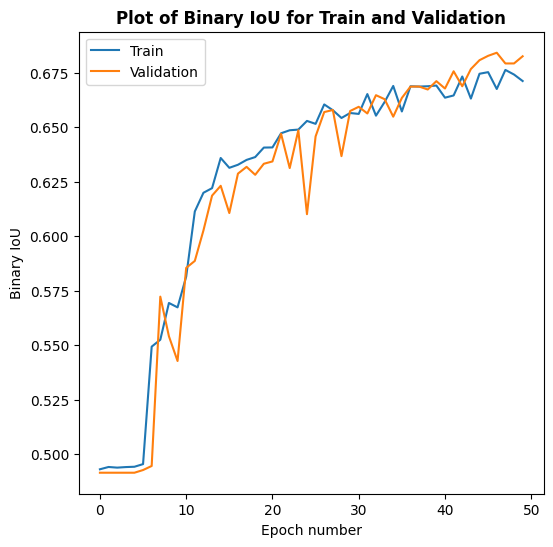

In [22]:
plot_metrics(history,'binary_io_u', 'val_binary_io_u', 'Binary IoU')

A higher IoU value indicates that the predicted segmentation mask is more accurate and aligns closely with ground truth mask. It suggests that the model is learning to capture and localize objects in the image while training.

## **X. Performance on test set**

In [23]:
def plot_test_mask(seep_image, true_mask, pred_mask):
  '''Function to plot seep image, true mask image and the predicted mask image'''
  fig, axes = plt.subplots(1,3, figsize=(12,8))

  axes[0].imshow(seep_image)
  axes[0].set_title("Seep Image",fontweight='bold')
  axes[0].set_axis_off()

  axes[1].imshow(true_mask)
  axes[1].set_title("Ground Truth",fontweight='bold')
  axes[1].set_axis_off()

  axes[2].imshow(pred_mask)
  axes[2].set_title("Prediction",fontweight='bold')
  axes[2].set_axis_off()
  plt.show()

3/3 [==============================] - 2s 874ms/step





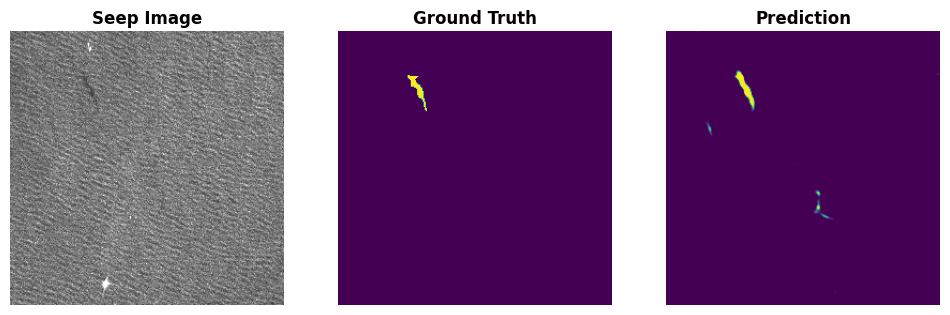

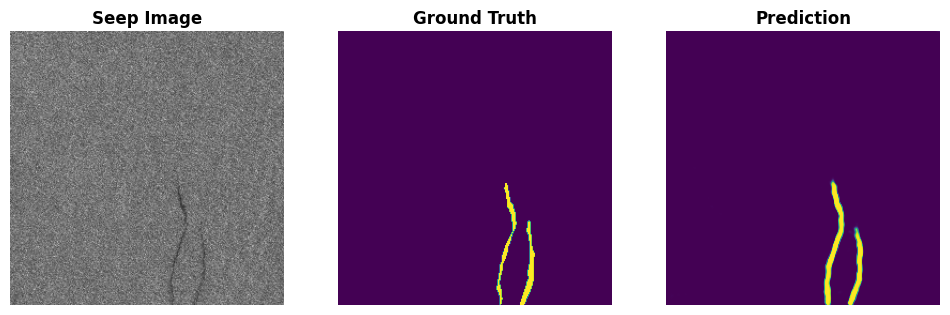

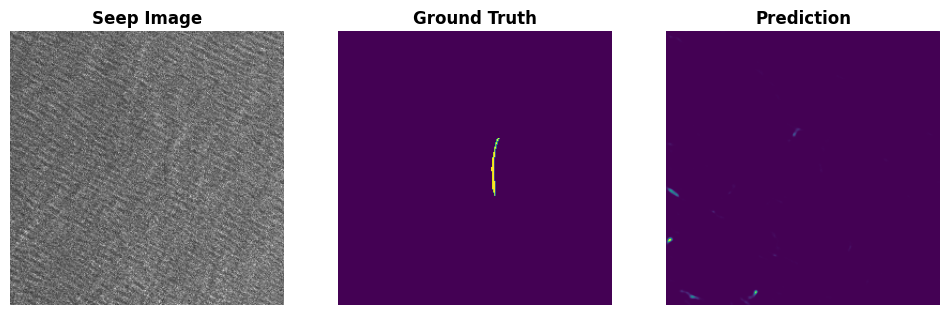

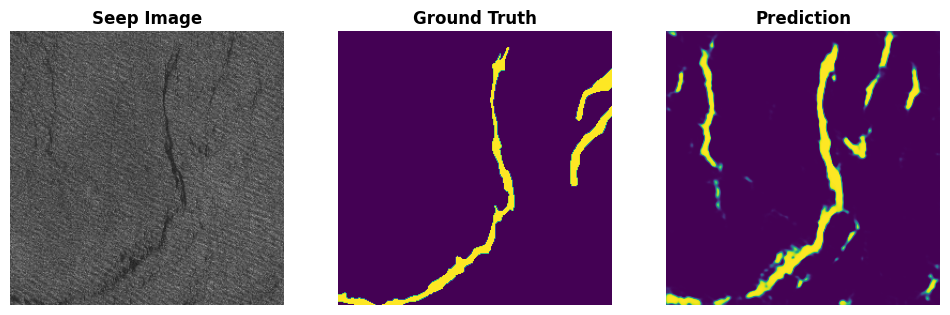

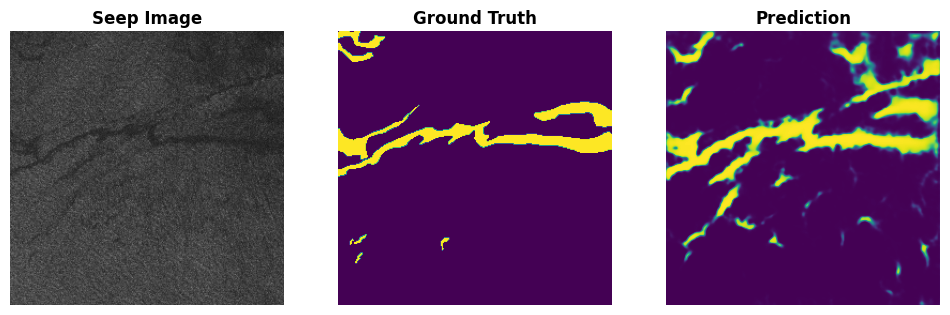

In [24]:
pred_label = model.predict(X_test)
#generate 5 random images to visualize the performance
random_idx = [random.randint(0, len(X_test)) for _ in range(5)]
for i in random_idx:
    print('\n\n')
    plot_test_mask(X_test[i], y_test[i][:,:,0], pred_label[i][:,:,0])


From the above images, we can say that the model was successfully able to learn the segmentation task as the prediction images are similar to the ground truth images for the test set.

In [25]:
test_loss, test_iou, test_dice_coef = model.evaluate(X_test, y_test)

print("Test Loss=",test_loss)
print("Test IoU=",test_iou)
print("Test Dice Coefficient=",test_dice_coef)


3/3 [==============================] - 0s 80ms/step - loss: 0.5665 - dice_coef: 0.5046 - binary_io_u: 0.6729
Test Loss= 0.5665467381477356
Test IoU= 0.5046183466911316
Test Dice Coefficient= 0.6728772521018982


# **CONCLUSION**

The U-Net architecture helps the model in learning the task of segmentation. Dice Loss and BCE Loss are the popular loss functions used in image segmentation. A combination of the two helps as dice measures the overlap between the predicted segmentation mask and the ground truth mask and BCE measures cross-entropy between predicted pixel-wise probabilities and the ground truth masks.

From the predicted and the groud truth images of the test set, we can see that the model is able to learn the task of segmentation.

In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/seep/final_model/my_model_unet')

# save the model weights
model.save_weights('/content/drive/MyDrive/seep/final_model/my_model_unet_weights')